**Recommender Systems:-**

Recommender System is a system that seeks to predict or filter preferences according to the user’s choices. Recommender systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general.
Here in this notebook we are basically going to discuss about two types of recommender systems, namely: Demographic filtering and Collaborative filtering.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('/content/sample_data/movies.csv')
df2 = pd.read_csv('/content/sample_data/credits.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,19

In [ ]:
df1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,FALSE,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,FALSE,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,FALSE,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,FALSE,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,FALSE,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",11/17/2011,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,FALSE,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/1/2003,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,FALSE

In [ ]:
df2

,cast,crew,id,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 1656,Unnamed: 1657,Unnamed: 1658,Unnamed: 1659,Unnamed: 1660,Unnamed: 1661,Unnamed: 1662,Unnamed: 1663,Unnamed: 1664,Unnamed: 1665,Unnamed: 1666,Unnamed: 1667,Unnamed: 1668,Unnamed: 1669,Unnamed: 1670,Unnamed: 1671,Unnamed: 1672,Unnamed: 1673,Unnamed: 1674,Unnamed: 1675,Unnamed: 1676,Unnamed: 1677,Unnamed: 1678,Unnamed: 1679,Unnamed: 1680,Unnamed: 1681,Unnamed: 1682,Unnamed: 1683,Unnamed: 1684,Unnamed: 1685,Unnamed: 1686,Unnamed: 1687,Unnamed: 1688,Unnamed: 1689,Unnamed: 1690,Unnamed: 1691,Unnamed: 1692,Unnamed: 1693,Unnamed: 1694,Unnamed: 1695
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9648,"[{'cast_id': 1, 'character': 'Casey Edwards', ...","[{'credit_id': '52fe451c9251416c91027d39', 'de...",33477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9649,"[{'cast_id': 1, 'character': 'Peter Sellers', ...","[{'credit_id': '52fe43929251416c75015b2d', 'de...",106

In [ ]:
df1.shape

(45466, 24)

In [ ]:
df2.shape

(9653, 1696)

In [ ]:
df2.rows = ['id','title','cast','crew']
df1= df1.merge(df2,on='id')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [ ]:
df1.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,...,Unnamed: 1656,Unnamed: 1657,Unnamed: 1658,Unnamed: 1659,Unnamed: 1660,Unnamed: 1661,Unnamed: 1662,Unnamed: 1663,Unnamed: 1664,Unnamed: 1665,Unnamed: 1666,Unnamed: 1667,Unnamed: 1668,Unnamed: 1669,Unnamed: 1670,Unnamed: 1671,Unnamed: 1672,Unnamed: 1673,Unnamed: 1674,Unnamed: 1675,Unnamed: 1676,Unnamed: 1677,Unnamed: 1678,Unnamed: 1679,Unnamed: 1680,Unnamed: 1681,Unnamed: 1682,Unnamed: 1683,Unnamed: 1684,Unnamed: 1685,Unnamed: 1686,Unnamed: 1687,Unnamed: 1688,Unnamed: 1689,Unnamed: 1690,Unnamed: 1691,Unnamed: 1692,Unnamed: 1693,Unnamed: 1694,Unnamed: 1695
0,FALSE,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,7007,tt0107969,en,Rising Sun,When a prostitute is found dead in a Los Angel...,6.27908,/d07rjd7e54ClVLoixmf6alTiDDj.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",7/30/1993,107198790.0,125.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Released,A collision of East and West. A conspiracy of ...,Rising Sun,False,5.8,188.0,"[{'cast_id': 6, 'character': 'Capt. John Conno...","[{'credit_id': '5388491cc3a3681ad700450b', 'de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FALSE,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,10467,tt0111001,en,The Road to Wellville,An unhappy young couple visit the infamous Kel...,3.41618,/3i5zFVewQMGlcPhsHoHmf0VHV02.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/28/1994,0.0,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comedy of the heart and other organs.,The Road to Wellville,False,5.5,43.0,"[{'cast_id': 1, 'character': 'Dr. John Harvey ...","[{'credit_id': '52fe43759251416c75011351', 'de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FALSE,"{'id': 5547, 'name': 'RoboCop Collection', 'po...",22000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,5550,tt0107978,en,RoboCop 3,The mega corporation Omni Consumer Products is...,8.6858,/9bRy74b1AZEJD5omzWPPAptPfa7.jpg,"[{'name': 'Orion Pictures', 'id': 41}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/17/1993,10696210.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,He's back to lay down the law.,RoboCop 3,False,4.2,309.0,"[{'cast_id': 11, 'character': 'RoboCop', 'cred...","[{'credit_id': '52fe440ec3a36847f807fb97', 'de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FALSE,NaN,20000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,8005,tt0107977,en,Robin Hood: Men in Tights,Robin Hood comes home after fighting in the Cr...,17.1367,/3pd3sdot0HfQTFzqgTUzaF4kcxP.jpg,"[{'name': 'Gaumont', 'id': 9}, {'name': 'Twent...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",7/28/1993,35739755.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The legend had it coming... Find out where Rob...,Robin Hood: Men in Tights,False,6.4,575.0,"[{'cast_id': 1, 'character': 'Robin Hood', 'cr...","[{'credit_id': '52fe448cc3a36847f809c429', 'de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...

**DEMOGRAPHIC FILTERING:-** -

What is Demographic Filtering?

They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Before getting started with this type of filtering :-

We need a metric to score or rate movie.

->Calculate the score for every movie
->Sort the scores and recommend the best rated movie to the users.
->We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, We'll be using IMDB's weighted rating (wr) which is given as :-

Weighted Rating(WR) = ((v/v+m)*R) + ((v/v+m)*C)
where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report
We already have v(vote_count) and R (vote_average) and C can be calculated as:

In [ ]:
C= df1['vote_average'].mean()
C

6.101683840160848

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [ ]:
m= df1['vote_count'].quantile(0.9)
m

281.0

Now, we can filter out the movies that qualify for the chart

In [ ]:
q_movies = df1.copy().loc[df1['vote_count'] >= m]
q_movies.shape

(399, 1719)

We see that there are 399 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# To define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [ ]:
#To sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#To print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
323,The Godfather,6024.0,8.5,8.393112
10,Schindler's List,4436.0,8.3,8.169042
74,The Silence of the Lambs,4549.0,8.1,7.983742
1278,The Lord of the Rings: The Fellowship of the Ring,8892.0,8.0,7.941848
1718,The Lord of the Rings: The Two Towers,7641.0,8.0,7.932665
1783,City of God,1852.0,8.2,7.923569
367,Rear Window,1531.0,8.2,7.874599
1761,The Pianist,1927.0,8.1,7.845685
24,Blade Runner,3833.0,7.9,7.777169
3796,Oldboy,2000.0,8.0,7.766143


Superb! We have made our first(though very basic) recommender. We can find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

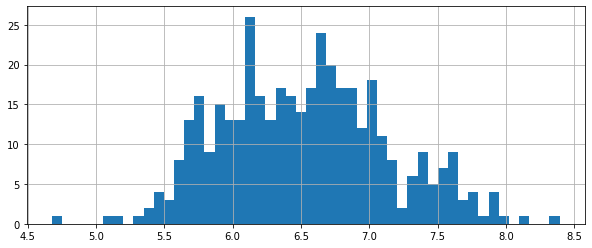

In [ ]:
plt.figure(figsize =(10, 4)) 
q_movies['score'].hist(bins = 50) 

**COLLABORATIVE FILTERING:-**

This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

In [ ]:
!pip install surprise

Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv('/content/sample_data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8943  0.8993  0.8970  0.8974  0.8955  0.8967  0.0017  
MAE (testset)     0.6889  0.6920  0.6878  0.6930  0.6931  0.6910  0.0022  
Fit time          5.25    5.19    5.33    5.25    5.23    5.25    0.05    
Test time         0.14    0.14    0.14    0.14    0.13    0.14    0.00    


{'fit_time': (5.251612901687622,
  5.186136245727539,
  5.332967281341553,
  5.249790906906128,
  5.234451532363892),
 'test_mae': array([0.68888593, 0.69201206, 0.68784481, 0.69304031, 0.69307432]),
 'test_rmse': array([0.89430333, 0.89932525, 0.89702644, 0.89737263, 0.89551548]),
 'test_time': (0.13769865036010742,
  0.1449885368347168,
  0.14060711860656738,
  0.13804030418395996,
  0.13478469848632812)}

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
algo.fit(trainset)

Let us pick user with user Id 1 and check the ratings she/he has given.

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6447825799667632, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.644. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.